In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [52]:
import numpy as np
import halfspace.load as hs
import halfspace.projections as hsp
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
stress_file = '../stress_arrays/wnfs_topo_stress.h5'

sdb = h5py.File(stress_file, 'r')

In [4]:
sdb['xx_MPa'].shape, np.product(sdb['xx_MPa'].shape)

((1397, 1674, 51), 119267478)

In [55]:
conv_shape = sdb['xx_MPa'].shape

In [5]:
with open('../../nepal_2015/stress_arrays/stress_calcs_meta.json') as f:
    s_meta = json.load(f)

In [6]:
s_meta

{'b_conv_mode': 'valid', 'c_conv_mode': 'same', 'z_max': 30000, 'z_res': 500}

In [7]:
z_len = sdb['xx_MPa'].shape[2]

z_vec = np.linspace(s_meta['z_res'], s_meta['z_max'], z_len)

In [53]:
with open('../data/dem/wnfs_dem_utm45_meta.json', 'r') as f:
    d_meta = json.load(f)

In [54]:
d_meta

{'east_max': 868665.9344798587,
 'east_min': -368334.0655201413,
 'lat_max': 34.05579460696701,
 'lat_min': 23.96819102557579,
 'lon_max': 90.99354408576976,
 'lon_min': 78.4860095977793,
 'n_cols': 2474,
 'n_rows': 2197,
 'north_max': 3775544.3200867064,
 'north_min': 2677044.3200867064,
 'upper_left_x': -368334.0655201413,
 'upper_left_y': 3775544.3200867064,
 'x_res_m': 500.0,
 'x_rotation': 0.0,
 'y_res_m': 500.0,
 'y_rotation': 0.0}

In [100]:
conv_shape

(1397, 1674, 51)

In [115]:
dem_e = np.linspace(d_meta['east_min'], d_meta['east_max'], d_meta['n_cols'])
dem_n = np.linspace(d_meta['north_min'], d_meta['north_max'], d_meta['n_rows'])

convo_e = hs._centered(dem_e, conv_shape[1])
convo_n = hs._centered(dem_n, conv_shape[0])

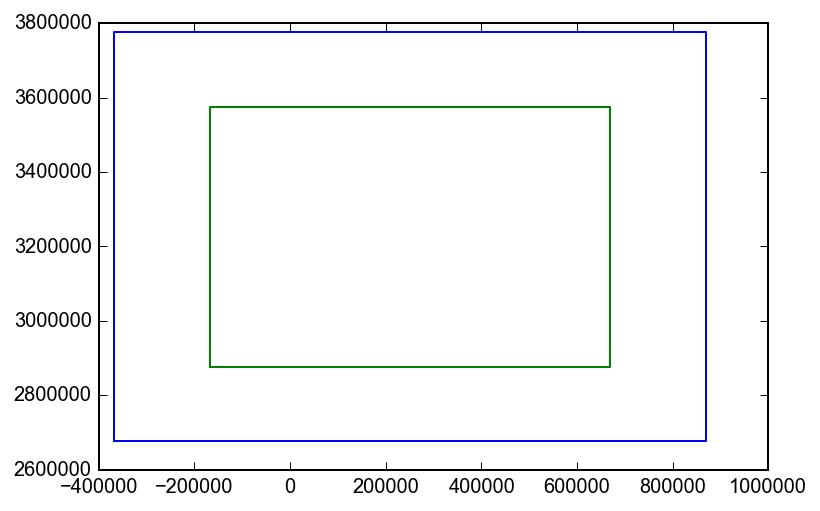

In [116]:
plt.plot( (dem_e.min(), dem_e.max(), dem_e.max(), dem_e.min(), dem_e.min()),
          (dem_n.min(), dem_n.min(), dem_n.max(), dem_n.max(), dem_n.min()))

plt.plot( (convo_e.min(), convo_e.max(), convo_e.max(), convo_e.min(), convo_e.min()),
          (convo_n.min(), convo_n.min(), convo_n.max(), convo_n.max(), convo_n.min()))

In [8]:
z_vec

array([   500.,   1090.,   1680.,   2270.,   2860.,   3450.,   4040.,
         4630.,   5220.,   5810.,   6400.,   6990.,   7580.,   8170.,
         8760.,   9350.,   9940.,  10530.,  11120.,  11710.,  12300.,
        12890.,  13480.,  14070.,  14660.,  15250.,  15840.,  16430.,
        17020.,  17610.,  18200.,  18790.,  19380.,  19970.,  20560.,
        21150.,  21740.,  22330.,  22920.,  23510.,  24100.,  24690.,
        25280.,  25870.,  26460.,  27050.,  27640.,  28230.,  28820.,
        29410.,  30000.])

In [36]:
depth_ind = 12
depth = z_vec[depth_ind]
depth

7580.0

In [37]:
xx_stress = sdb['xx_MPa'][:,:,depth_ind]
yy_stress = sdb['yy_MPa'][:,:,depth_ind]
zz_stress = sdb['zz_MPa'][:,:,depth_ind]
xy_stress = sdb['xy_MPa'][:,:,depth_ind]
xz_stress = sdb['xz_MPa'][:,:,depth_ind]
yz_stress = sdb['yz_MPa'][:,:,depth_ind]

In [38]:
T = pd.read_csv('../results/T_best.csv', index_col=0, header=None, squeeze=True)
T

0
txx    0.096860
txy   -0.199583
tyy    0.050988
Name: 1, dtype: float64

In [69]:
rg = 9.81 * 2700 / 1e6

rgz = rg *depth #* 0
#txx, tyy, txy = T.txx * rgz, T.tyy * rgz, T.txy * rgz

txx, tyy, txy = 0.033 * rgz, 0.467 * rgz, 0.125 * rgz # experimental

stress_scale = 0.4
txx *= stress_scale
tyy *= stress_scale
txy *= stress_scale


txx, tyy, txy

(2.650183272, 37.504108727999999, 10.038573)

In [70]:
rgz

200.77145999999999

In [71]:
nrows, ncols = xx_stress.shape

In [72]:
sd = {'xx': xx_stress + txx,
      'yy': yy_stress + tyy,
      'zz': zz_stress,
      'xy': xy_stress + txy,
      'xz': xz_stress,
      'yz': yz_stress}

In [73]:
def deform_style(T, P):
    
    return P.plunge - T.plunge
    
    
def deform_style_from_tensor(S):
    T, N, P = hsp.get_princ_axes_xyz(S)
    
    return deform_style(T, P)


def make_S(sd, i, j):
    
    return hsp.make_xyz_stress_tensor(sig_xx=sd['xx'][i,j],
                                      sig_yy=sd['yy'][i,j],
                                      sig_zz=sd['zz'][i,j],
                                      sig_xy=sd['xy'][i,j],
                                      sig_xz=sd['xz'][i,j],
                                      sig_yz=sd['yz'][i,j])

def def_style_from_ij(sd, i,j):
    
    S = make_S(sd, i, j)
    
    return deform_style_from_tensor(S)

In [74]:
S_test = hsp.make_xyz_stress_tensor(sig_xx=100, sig_yy=35, sig_zz = 20)

deform_style_from_tensor(S_test)

-90.0

In [87]:
n_skip = 1

def_styles = [def_style_from_ij(sd, i, j) for i in range(nrows)[::n_skip] 
                                              for j in range(ncols)[::n_skip]]

In [88]:
def_styles = np.array(def_styles)

In [89]:
def_styles.shape

(2338578,)

In [90]:
def_styles = def_styles.reshape((len(range(nrows)[::n_skip]), 
                                 len(range(ncols)[::n_skip])))

In [ ]:
def_styles.astype()

In [91]:
import gdal

In [117]:
def array_to_raster(array):
    
    arr32 = np.flipud( array.astype('float32') )
    
    dst_filename = '../results/example_deform_style.tif'
    
    driver = gdal.GetDriverByName('GTiff')
    
    dataset = driver.Create(
        dst_filename,
        ncols,
        nrows,
        1,
        gdal.GDT_Float32, )
    
    dataset.SetGeoTransform((convo_e.min(),
                            500.,
                            0,
                            convo_n.max(),
                            0,
                            -500.))
    dataset.SetProjection('EPSG:32645')
    dataset.GetRasterBand(1).WriteArray(arr32)
    dataset.FlushCache()

In [118]:
array_to_raster(def_styles)

In [113]:
ncols, nrows

(1674, 1397)

In [114]:
len(convo_e), len(convo_n)

(1397, 1674)

/Users/itchy/src/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


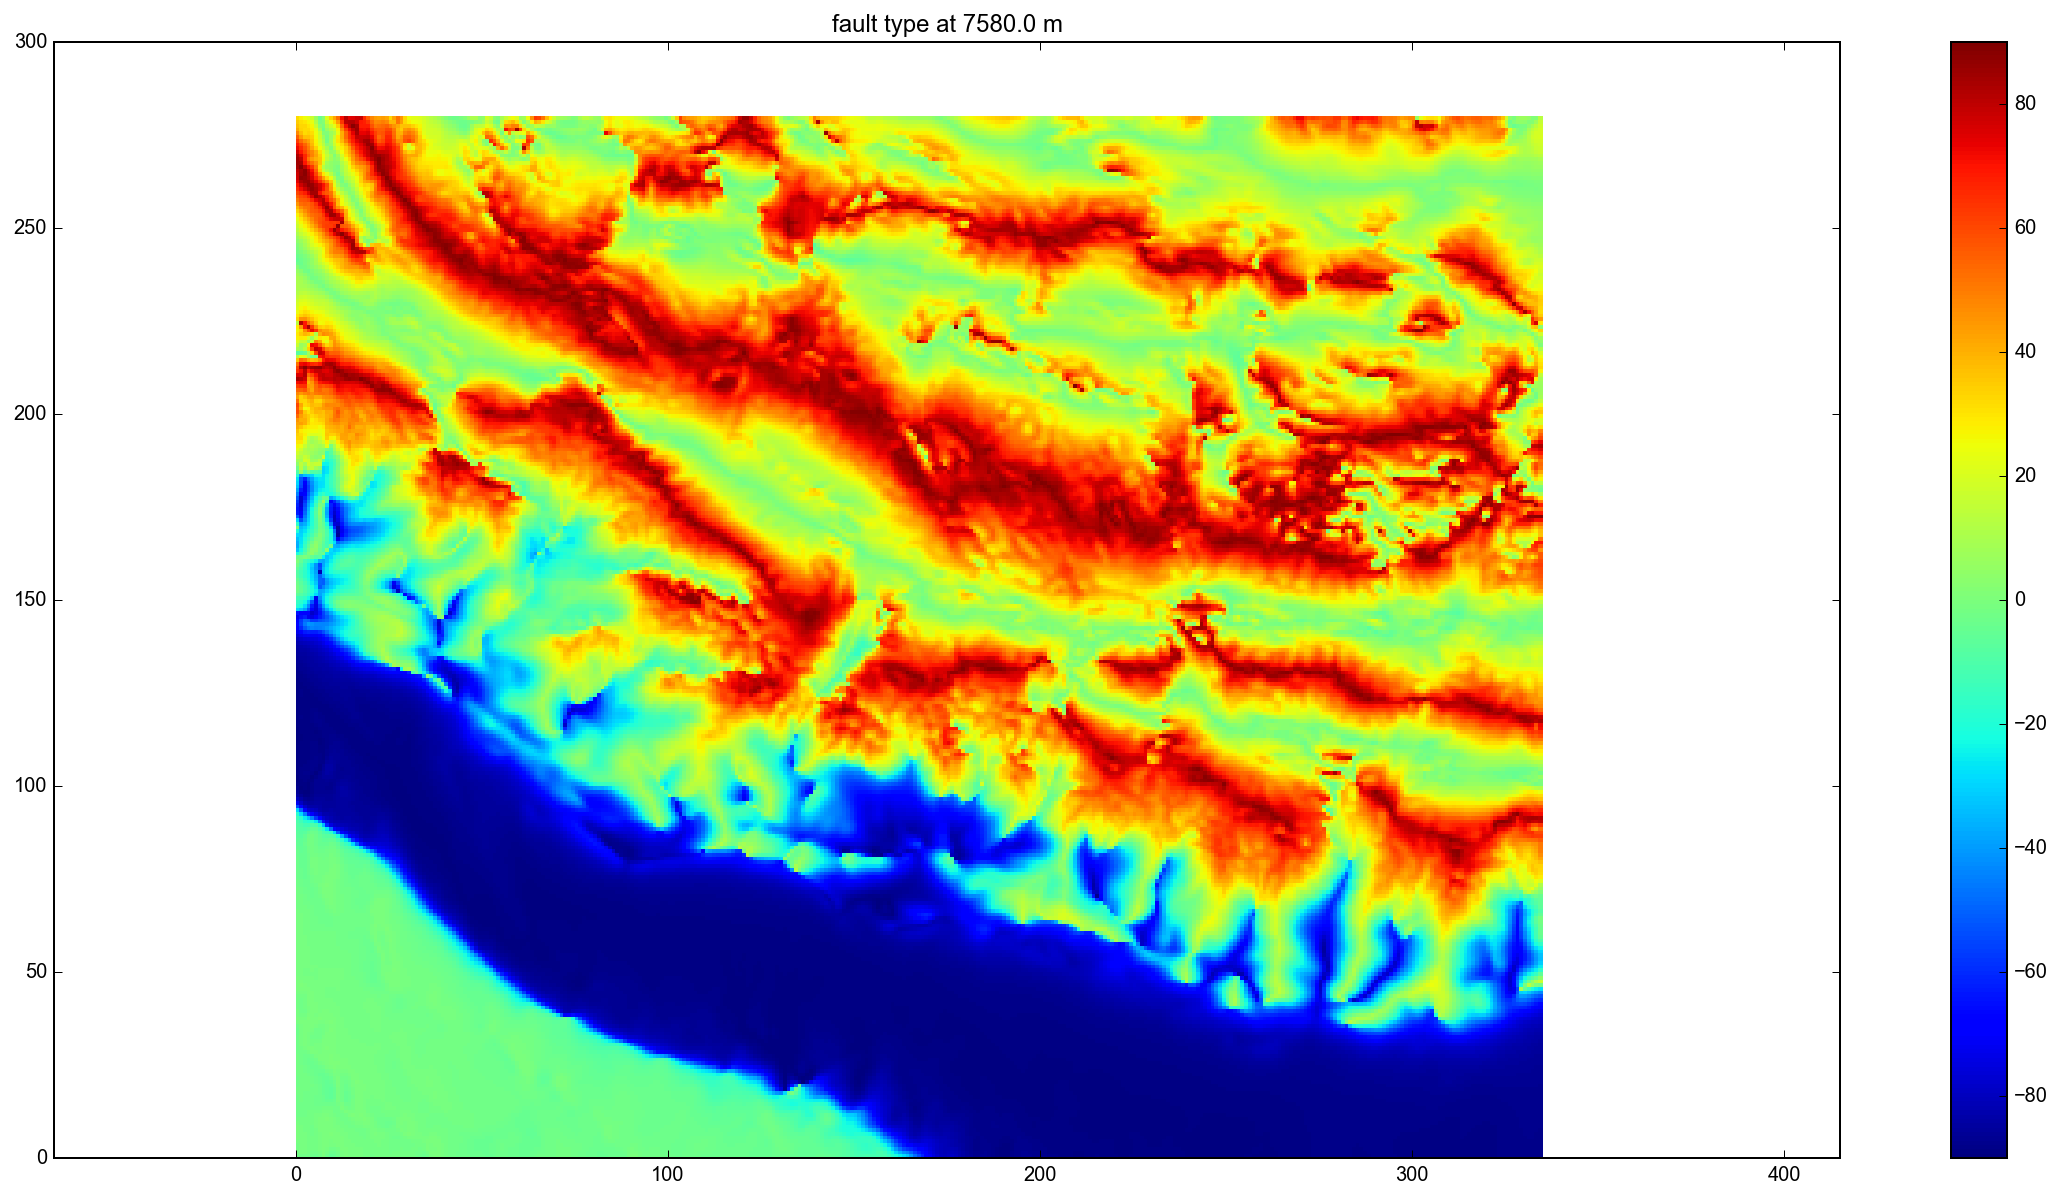

In [86]:
plt.figure(figsize=(20,10))

p = plt.pcolormesh(def_styles, vmax=90, vmin=-90)
plt.colorbar()
#plt.contour(def_styles, [30, -30], colors='k', lw=0.25)
plt.axis('equal')
plt.title('fault type at {} m'.format(depth))

plt.show()